In [1]:
from collections import defaultdict
from itertools import count
import matplotlib.pyplot as plt
from metaphone import doublemetaphone
import pandas as pd
from statistics import mean
import textdistance
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_validate, StratifiedKFold

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

# Load Data

Load your folds in the following cell:

In [2]:
dir_name = "../results/edit_emb20_lay8"

folds = []

for i in range(5):
  test_csv = os.path.join(dir_name, f"test_k{i}.csv")
  df = pd.read_csv(test_csv, usecols=["name1", "name2", "label"])
  df = df.astype({"label": bool, "name1": str, "name2": str})
  df = df.rename(columns={"name1": "name_a", "name2": "name_b"})

  folds.append(df)

Loads data from the 1871/1878 dataset

Once your folds are loaded, the output of the following commands should look roughly like this:

In [3]:
len(folds)

5

In [4]:
folds[0]

,name_a,name_b,label
0,dessell,pessall,False
1,ellgood,elwood,False
2,ermann,erman,True
3,koland,nowland,False
4,radebach,rasbach,False
...,...,...,...
14995,tildsley,bertini,False
14996,rieck,riek,False
14997,dippery,brohart,False
14998,wipperman,wippermann,True


# Generate Features

In [5]:
def compare_dm1(s1, s2):
    return textdistance.levenshtein.normalized_similarity(doublemetaphone(s1)[0],doublemetaphone(s2)[0])

def compare_dm2(s1, s2):
    return textdistance.levenshtein.normalized_similarity(doublemetaphone(s1)[1],doublemetaphone(s2)[1])

In [6]:
%%time
for pairs in folds:
    pairs['levenshtein'] = [textdistance.levenshtein.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['jaro'] = [textdistance.jaro.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['jaro_winkler'] = [textdistance.jaro_winkler.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['jaccard'] = [textdistance.jaccard.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['sorensen_dice'] = [textdistance.sorensen_dice.normalized_similarity(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['dm1'] = [compare_dm1(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]
    pairs['dm2'] = [compare_dm2(x, y) for x, y in pairs[['name_a', 'name_b']].itertuples(index=False)]

    pairs['vowels_a'] = pairs['name_a'].apply(lambda x: sum(map(x.count, 'aeiou')))
    pairs['vowels_b'] = pairs['name_b'].apply(lambda x: sum(map(x.count, 'aeiou')))
    pairs['consonants_a'] = pairs['name_a'].str.len() - pairs['vowels_a']
    pairs['consonants_b'] = pairs['name_b'].str.len() - pairs['vowels_b']
    pairs['vowels'] = (pairs['vowels_a'] - pairs['vowels_b']).abs()
    pairs['vowels'] = 1 - (pairs['vowels'] / pairs['vowels'].max())
    pairs['consonants'] = (pairs['consonants_a'] - pairs['consonants_b']).abs()
    pairs['consonants'] = 1 - (pairs['consonants'] / pairs['consonants'].max())
    pairs['characters'] = (pairs['name_a'].str.len() - pairs['name_b'].str.len()).abs()
    pairs['characters'] = 1 - (pairs['characters'] / pairs['characters'].max())
    pairs = pairs.drop(columns=['vowels_a', 'vowels_b', 'consonants_a', 'consonants_b'])

CPU times: user 59.8 s, sys: 4.52 s, total: 1min 4s
Wall time: 1min 25s


# Classification

In [7]:
%%time
scores = defaultdict(list)
y_prob = []
name_a = []
name_b = []
labels = []

rf_y_pred = []

for test_fold_index in range(len(folds)):
    val_fold_index = test_fold_index - 1 if test_fold_index - 1 >= 0 else len(folds) - 1

    X_train = pd.DataFrame()
    y_train = pd.Series(dtype=bool)
    for fold_index in range(len(folds)):
        if fold_index != test_fold_index and fold_index != val_fold_index:
            X_train = pd.concat([X_train, folds[fold_index].drop(columns=['name_a', 'name_b', 'label'])])
            y_train = pd.concat([y_train, folds[fold_index]['label']])
    name_a = name_a + folds[test_fold_index]["name_a"].values.tolist()
    name_b = name_b + folds[test_fold_index]["name_b"].values.tolist()
    X_test = folds[test_fold_index].drop(columns=['name_a', 'name_b', 'label'])
    y_test = folds[test_fold_index]['label']
    
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    rf_y_pred += np.array(y_pred).tolist()

    scores['test_precision'].append(precision_score(y_test, y_pred))
    scores['test_recall'].append(recall_score(y_test, y_pred))
    scores['f1_score'].append(f1_score(y_test, y_pred))

    yt = np.array(y_test)
    yp = np.array(y_pred)

    to_labels = yt.astype(int).tolist()
    labels = labels + to_labels

    scores['tp'].append(np.count_nonzero(yt & yp))
    scores['tn'].append(np.count_nonzero(np.logical_not(yt) & np.logical_not(yp)))
    scores['fp'].append(np.count_nonzero(np.logical_not(yt) & yp))
    scores['fn'].append(np.count_nonzero(yt & np.logical_not(yp)))

    y_prob += [x[1] for x in clf.predict_proba(X_test)]

print({k: mean(v) for k, v in scores.items()})

KeyboardInterrupt: 

In [ ]:
# SAVING TO FILE
# ML Results
yt = np.array(labels).astype(int)
yp = np.array(rf_y_pred).astype(int)

tp = (yt & yp).astype(int)
tn = (np.logical_not(yt) & np.logical_not(yp)).astype(int)
fp = (np.logical_not(yt) & yp).astype(int)
fn = (yt & np.logical_not(yp)).astype(int)

df = pd.DataFrame(list(zip(name_a, name_b, yp, yt, tp, tn, fp, fn)), columns =['name_a', 'name_b', 'score', 'label', 'tp', 'tn', 'fp', 'fn'])
df.to_csv(os.path.join(dir_name, "RF_results.csv"))

# DL Results
model_scores = []
for i in range(5):
  test_csv = os.path.join(dir_name, f"test_k{i}.csv")
  df = pd.read_csv(test_csv, usecols=["model_score", ])
  model_scores += df["model_score"].values.tolist()

precision, recall, thresholds = precision_recall_curve(labels, model_scores)

f_score_list = list()
for pre, rec in zip(precision, recall):
    lower = pre + rec
    if lower == 0.0:
        lower = 0.00000001
    
    f_score_list.append(2 * (pre * rec) / lower)

threshold_idx = np.argmax(f_score_list)
threshold_final = thresholds[threshold_idx]

DL_binary_label = np.array(model_scores) >= threshold_final
DL_binary_label = DL_binary_label.astype(int)

yt = np.array(labels)
yp = np.array(DL_binary_label).astype(int)

tp = (yt & yp).astype(int)
tn = (np.logical_not(yt) & np.logical_not(yp)).astype(int)
fp = (np.logical_not(yt) & yp).astype(int)
fn = (yt & np.logical_not(yp)).astype(int)

df = pd.DataFrame(list(zip(name_a, name_b, np.array(labels).astype(int), DL_binary_label, tp, tn, fp, fn)), columns =['name_a', 'name_b', 'score', 'label', 'tp', 'tn', 'fp', 'fn'])
df.to_csv(os.path.join(dir_name, "DL_results.csv"))

## Creating Venn Diagram

In [14]:
df_rf = pd.read_csv(os.path.join(dir_name, "RF_results.csv"))
df_dl = pd.read_csv(os.path.join(dir_name, "DL_results.csv"))

rf_tp = df_rf.loc[df_rf['tp'] == 1].to_dict('records')
rf_tn = df_rf.loc[df_rf['tn'] == 1].to_dict('records')
rf_fp = df_rf.loc[df_rf['fp'] == 1].to_dict('records')
rf_fn = df_rf.loc[df_rf['fn'] == 1].to_dict('records')

print(rf_tp)

rf_tp_names = {row['name_a'] + "_" + row['name_b'] for row in rf_tp}
rf_tn_names = {row['name_a'] + "_" + row['name_b'] for row in rf_tn}
rf_fp_names = {row['name_a'] + "_" + row['name_b'] for row in rf_fp}
rf_fn_names = {row['name_a'] + "_" + row['name_b'] for row in rf_fn}

dl_tp = df_dl.loc[df_dl['tp'] == 1].to_dict('records')
dl_tn = df_dl.loc[df_dl['tn'] == 1].to_dict('records')
dl_fp = df_dl.loc[df_dl['fp'] == 1].to_dict('records')
dl_fn = df_dl.loc[df_dl['fn'] == 1].to_dict('records')

dl_tp_names = {row['name_a'] + "_" + row['name_b'] for row in dl_tp}
dl_tn_names = {row['name_a'] + "_" + row['name_b'] for row in dl_tn}
dl_fp_names = {row['name_a'] + "_" + row['name_b'] for row in dl_fp}
dl_fn_names = {row['name_a'] + "_" + row['name_b'] for row in dl_fn}

total_tp = rf_tp_names.union(dl_tp_names)
total_fp = rf_fp_names.union(dl_tn_names)
total_tn = rf_tn_names.union(dl_fp_names)
total_fn = rf_tn_names.union(dl_fn_names)

plt.figure(figsize=(8, 8))
plt.title(f'True Positives')
venn2(
    (dl_tp_names, rf_tp_names),
    set_labels = ('Deep Learning', 'Random Forest'),
    subset_label_formatter=lambda x: f'{x:,}\n{x / len(total_tp) * 100:.1f}%'
)
plt.savefig(f"{dir_name}/TP_venn.jpg")
plt.clf()

plt.figure(figsize=(8, 8))
plt.title(f'False Positives')
venn2(
    (dl_fp_names, rf_fp_names),
    set_labels = ('Deep Learning', 'Random Forest'),
    subset_label_formatter=lambda x: f'{x:,}\n{x / len(total_tp) * 100:.1f}%'
)
plt.savefig(f"{dir_name}/FP_venn.jpg")
plt.clf()

plt.figure(figsize=(8, 8))
plt.title(f'True Negatives')
venn2(
    (dl_tn_names, rf_tn_names),
    set_labels = ('Deep Learning', 'Random Forest'),
    subset_label_formatter=lambda x: f'{x:,}\n{x / len(total_tp) * 100:.1f}%'
)
plt.savefig(f"{dir_name}/TN_venn.jpg")
plt.clf()

plt.figure(figsize=(8, 8))
plt.title(f'False Negatives')
venn2(
    (dl_fn_names, rf_fn_names),
    set_labels = ('Deep Learning', 'Random Forest'),
    subset_label_formatter=lambda x: f'{x:,}\n{x / len(total_tp) * 100:.1f}%'
)
plt.savefig(f"{dir_name}/FN_venn.jpg")
plt.clf()

[{'Unnamed: 0': 2, 'name_a': 'ermann', 'name_b': 'erman', 'score': 1, 'label': 1, 'tp': 1, 'tn': 0, 'fp': 0, 'fn': 0}, {'Unnamed: 0': 5, 'name_a': 'rohrbacker', 'name_b': 'rohrbacher', 'score': 1, 'label': 1, 'tp': 1, 'tn': 0, 'fp': 0, 'fn': 0}, {'Unnamed: 0': 7, 'name_a': 'hauger', 'name_b': 'hanger', 'score': 1, 'label': 1, 'tp': 1, 'tn': 0, 'fp': 0, 'fn': 0}, {'Unnamed: 0': 21, 'name_a': 'rampley', 'name_b': 'ramply', 'score': 1, 'label': 1, 'tp': 1, 'tn': 0, 'fp': 0, 'fn': 0}, {'Unnamed: 0': 22, 'name_a': 'crowe', 'name_b': 'crow', 'score': 1, 'label': 1, 'tp': 1, 'tn': 0, 'fp': 0, 'fn': 0}, {'Unnamed: 0': 23, 'name_a': 'drye', 'name_b': 'dry', 'score': 1, 'label': 1, 'tp': 1, 'tn': 0, 'fp': 0, 'fn': 0}, {'Unnamed: 0': 26, 'name_a': 'cleverley', 'name_b': 'cleverly', 'score': 1, 'label': 1, 'tp': 1, 'tn': 0, 'fp': 0, 'fn': 0}, {'Unnamed: 0': 27, 'name_a': 'settlemeyer', 'name_b': 'settlemyer', 'score': 1, 'label': 1, 'tp': 1, 'tn': 0, 'fp': 0, 'fn': 0}, {'Unnamed: 0': 30, 'name_a':

TypeError: can only concatenate str (not "float") to str

In [ ]:
#Creating the csv for R analysis on vowels and etc

df_rf = pd.read_csv(os.path.join(dir_name, "RF_results.csv"))
df_dl = pd.read_csv(os.path.join(dir_name, "DL_results.csv"))

df_rf["N_N"] = df_rf["name_a"] + "_" + df_rf["name_b"]
df_dl["N_N"] = df_dl["name_a"] + "_" + df_dl["name_b"]

fp_rf = df_rf.loc[df_rf['fp'] == 1]
fn_rf = df_rf.loc[df_rf['fn'] == 1]

fp_dl = df_dl.loc[df_dl['fp'] == 1]
fn_dl = df_dl.loc[df_dl['fn'] == 1]

fp_rf = fp_rf.drop(columns = ["label", "tp", "tn", "score", "fn", "Unnamed: 0"])
fn_rf = fn_rf.drop(columns = ["label", "tp", "tn", "fp", "score", "Unnamed: 0"])
fp_dl = fp_dl.drop(columns = ["label", "tp", "tn", "score", "fn", "Unnamed: 0"])
fn_dl = fn_dl.drop(columns = ["label", "tp", "tn", "fp", "score", "Unnamed: 0"])

fp_rf = fp_rf.rename(columns = {"fp": "RF"})
fn_rf = fn_rf.rename(columns = {"fn": "RF"})
fp_dl = fp_dl.rename(columns = {"fp": "DL"})
fn_dl = fn_dl.rename(columns = {"fn": "DL"})

fp = pd.merge(fp_rf, fp_dl[["name_a", "name_b", "DL"]], on = ["name_a", "name_b"], how = "outer")
fp = fp.fillna(0)

'''
fp.loc[fp['RF'] == 1, 'cat'] = 'RF'
fp.loc[fp['DL'] == 1, 'cat'] = 'DL'
fp.loc[(fp['DL'] == 1) & (fp['RF'] == 1), 'cat'] = 'BOTH'

fp = fp.to_dict('records')
for row in fp:
    row["length_diff"] = abs(len(row["name_a"]) - len(row["name_b"]))
    row["length_avg"] = (len(row["name_a"]) + len(row["name_b"])) / 2

    name_a_vowels = 0
    for let in row["name_a"]:
        if let in "aeiou":
            name_a_vowels += 1
    name_a_const = len(row["name_a"]) - name_a_vowels

    name_b_vowels = 0
    for let in row["name_b"]:
        if let in "aeiou":
            name_b_vowels += 1
    name_b_const = len(row["name_b"]) - name_b_vowels

    row["vowel_diff"] = abs(name_a_vowels - name_b_vowels)
    row["vowel_avg"] = abs(name_a_vowels + name_b_vowels) / 2

    row["const_diff"] = abs(name_a_const - name_b_const)
    row["const_avg"] = abs(name_a_const + name_b_const) / 2

    row["subset"] = 1 if (row["name_a"] in row["name_b"]) or (row["name_b"] in row["name_a"]) else 0
    row["copy"] = 1 if (row["name_a"] == row["name_b"]) and row["subset"] != 1 else 0

fp = pd.DataFrame(fp)
fp.to_csv(os.path.join(dir_name, "fp_master.csv"))
'''

fn = pd.merge(fn_rf, fn_dl[["name_a", "name_b", "DL"]], on = ["name_a", "name_b"], how = "outer")
fn = fn.fillna(0)

fn.loc[fn['RF'] == 1, 'cat'] = 'RF'
fn.loc[fn['DL'] == 1, 'cat'] = 'DL'
fn.loc[(fn['DL'] == 1) & (fn['RF'] == 1), 'cat'] = 'BOTH'

fn = fn.to_dict('records')
for row in fn:
    row["length_diff"] = abs(len(row["name_a"]) - len(row["name_b"]))
    row["length_avg"] = (len(row["name_a"]) + len(row["name_b"])) / 2

    name_a_vowels = 0
    for let in row["name_a"]:
        if let in "aeiou":
            name_a_vowels += 1
    name_a_const = len(row["name_a"]) - name_a_vowels

    name_b_vowels = 0
    for let in row["name_b"]:
        if let in "aeiou":
            name_b_vowels += 1
    name_b_const = len(row["name_b"]) - name_b_vowels

    row["vowel_diff"] = abs(name_a_vowels - name_b_vowels)
    row["vowel_avg"] = abs(name_a_vowels + name_b_vowels) / 2

    row["const_diff"] = abs(name_a_const - name_b_const)
    row["const_avg"] = abs(name_a_const + name_b_const) / 2

    row["subset"] = 1 if (row["name_a"] in row["name_b"]) or (row["name_b"] in row["name_a"]) else 0
    row["copy"] = 1 if (row["name_a"] == row["name_b"]) and row["subset"] != 1 else 0

fn = pd.DataFrame(fn)

fn.to_csv(os.path.join(dir_name, "fn_master.csv"))

In [ ]:
#Creating the csv for R analysis on vowels and etc

df_rf = pd.read_csv(os.path.join(dir_name, "RF_results.csv"))
df_dl = pd.read_csv(os.path.join(dir_name, "DL_results.csv"))

df_rf["N_N"] = df_rf["name_a"] + "_" + df_rf["name_b"]
df_dl["N_N"] = df_dl["name_a"] + "_" + df_dl["name_b"]

tp_rf = df_rf.loc[df_rf['tp'] == 1]
tn_rf = df_rf.loc[df_rf['tn'] == 1]

tp_dl = df_dl.loc[df_dl['tp'] == 1]
tn_dl = df_dl.loc[df_dl['tn'] == 1]

tp_rf = tp_rf.drop(columns = ["label", "fp", "fn", "score", "tn", "Unnamed: 0"])
tn_rf = tn_rf.drop(columns = ["label", "fp", "fn", "tp", "score", "Unnamed: 0"])
tp_dl = tp_dl.drop(columns = ["label", "fp", "fn", "score", "tn", "Unnamed: 0"])
tn_dl = tn_dl.drop(columns = ["label", "fp", "fn", "tp", "score", "Unnamed: 0"])

tp_rf = tp_rf.rename(columns = {"tp": "RF"})
tn_rf = tn_rf.rename(columns = {"tn": "RF"})
tp_dl = tp_dl.rename(columns = {"tp": "DL"})
tn_dl = tn_dl.rename(columns = {"tn": "DL"})

tp = pd.merge(tp_rf, tp_dl[["name_a", "name_b", "DL"]], on = ["name_a", "name_b"], how = "outer")
tp = tp.fillna(0)

tp.loc[tp['RF'] == 1, 'cat'] = 'RF'
tp.loc[tp['DL'] == 1, 'cat'] = 'DL'
tp.loc[(tp['DL'] == 1) & (tp['RF'] == 1), 'cat'] = 'BOTH'

tp = tp.to_dict('records')
#print(tp)
for row in tp:
    if row["name_a"] == "nau" or row["name_b"] == "nau":
        continue
    row["length_diff"] = abs(len(row["name_a"]) - len(row["name_b"]))
    row["length_avg"] = (len(row["name_a"]) + len(row["name_b"])) / 2

    name_a_vowels = 0
    for let in row["name_a"]:
        if let in "aeiou":
            name_a_vowels += 1
    name_a_const = len(row["name_a"]) - name_a_vowels

    name_b_vowels = 0
    for let in row["name_b"]:
        if let in "aeiou":
            name_b_vowels += 1
    name_b_const = len(row["name_b"]) - name_b_vowels

    row["vowel_diff"] = abs(name_a_vowels - name_b_vowels)
    row["vowel_avg"] = abs(name_a_vowels + name_b_vowels) / 2

    row["const_diff"] = abs(name_a_const - name_b_const)
    row["const_avg"] = abs(name_a_const + name_b_const) / 2

    row["subset"] = 1 if (row["name_a"] in row["name_b"]) or (row["name_b"] in row["name_a"]) else 0
    row["copy"] = 1 if (row["name_a"] == row["name_b"]) and row["subset"] != 1 else 0

tp = pd.DataFrame(tp)
tp.to_csv(os.path.join(dir_name, "tp_master.csv"))

tn = pd.merge(tn_rf, tn_dl[["name_a", "name_b", "DL"]], on = ["name_a", "name_b"], how = "outer")
tn = tn.fillna(0)

'''
tn.loc[tn['RF'] == 1, 'cat'] = 'RF'
tn.loc[tn['DL'] == 1, 'cat'] = 'DL'
tn.loc[(tn['DL'] == 1) & (tn['RF'] == 1), 'cat'] = 'BOTH'

tn = tn.to_dict('records')
for row in tn:
    row["length_diff"] = abs(len(row["name_a"]) - len(row["name_b"]))
    row["length_avg"] = (len(row["name_a"]) + len(row["name_b"])) / 2

    name_a_vowels = 0
    for let in row["name_a"]:
        if let in "aeiou":
            name_a_vowels += 1
    name_a_const = len(row["name_a"]) - name_a_vowels

    name_b_vowels = 0
    for let in row["name_b"]:
        if let in "aeiou":
            name_b_vowels += 1
    name_b_const = len(row["name_b"]) - name_b_vowels

    row["vowel_diff"] = abs(name_a_vowels - name_b_vowels)
    row["vowel_avg"] = abs(name_a_vowels + name_b_vowels) / 2

    row["const_diff"] = abs(name_a_const - name_b_const)
    row["const_avg"] = abs(name_a_const + name_b_const) / 2

    row["subset"] = 1 if (row["name_a"] in row["name_b"]) or (row["name_b"] in row["name_a"]) else 0
    row["copy"] = 1 if (row["name_a"] == row["name_b"]) and row["subset"] != 1 else 0

tn = pd.DataFrame(tn)

tn.to_csv(os.path.join(dir_name, "tn_master.csv"))
'''

'\ntn.loc[tn[\'RF\'] == 1, \'cat\'] = \'RF\'\ntn.loc[tn[\'DL\'] == 1, \'cat\'] = \'DL\'\ntn.loc[(tn[\'DL\'] == 1) & (tn[\'RF\'] == 1), \'cat\'] = \'BOTH\'\n\ntn = tn.to_dict(\'records\')\nfor row in tn:\n    row["length_diff"] = abs(len(row["name_a"]) - len(row["name_b"]))\n    row["length_avg"] = (len(row["name_a"]) + len(row["name_b"])) / 2\n\n    name_a_vowels = 0\n    for let in row["name_a"]:\n        if let in "aeiou":\n            name_a_vowels += 1\n    name_a_const = len(row["name_a"]) - name_a_vowels\n\n    name_b_vowels = 0\n    for let in row["name_b"]:\n        if let in "aeiou":\n            name_b_vowels += 1\n    name_b_const = len(row["name_b"]) - name_b_vowels\n\n    row["vowel_diff"] = abs(name_a_vowels - name_b_vowels)\n    row["vowel_avg"] = abs(name_a_vowels + name_b_vowels) / 2\n\n    row["const_diff"] = abs(name_a_const - name_b_const)\n    row["const_avg"] = abs(name_a_const + name_b_const) / 2\n\n    row["subset"] = 1 if (row["name_a"] in row["name_b"]) or (ro

In [ ]:
#Do analysis on some of the data
fp = pd.read_csv(os.path.join(dir_name, "fp_master.csv"))

val = fp.loc[fp['cat'] == 'DL']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "1.jpg"))
plt.clf()

print("BOTH diff LENGTH")
val = fp.loc[fp['cat'] == 'BOTH']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "2.jpg"))
plt.clf()

print("RF diff LENGTH")
val = fp.loc[fp['cat'] == 'RF']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "3.jpg"))
plt.clf()


print("DL diff VOWEL")
val = fp.loc[fp['cat'] == 'DL']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "4.jpg"))
plt.clf()

print("BOTH diff VOWEL")
val = fp.loc[fp['cat'] == 'BOTH']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "5.jpg"))
plt.clf()

print("RF diff VOWEL")
val = fp.loc[fp['cat'] == 'RF']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "6.jpg"))
plt.clf()



print("DL diff CONST")
val = fp.loc[fp['cat'] == 'DL']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "7.jpg"))
plt.clf()

print("BOTH diff CONST")
val = fp.loc[fp['cat'] == 'BOTH']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "8.jpg"))
plt.clf()

print("RF diff CONST")
val = fp.loc[fp['cat'] == 'RF']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "9.jpg"))
plt.clf()


print("DL diff SUBSET")
val = fp.loc[fp['cat'] == 'DL']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "10.jpg"))
plt.clf()

print("BOTH diff SUBSET")
val = fp.loc[fp['cat'] == 'BOTH']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "11.jpg"))
plt.clf()

print("RF diff SUBSET")
val = fp.loc[fp['cat'] == 'RF']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Subset Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "12.jpg"))
plt.clf()




print("DL diff COPY")
val = fp.loc[fp['cat'] == 'DL']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "13.jpg"))
plt.clf()

print("BOTH diff COPY")
val = fp.loc[fp['cat'] == 'BOTH']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "14.jpg"))
plt.clf()

print("RF diff COPY")
val = fp.loc[fp['cat'] == 'RF']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "15.jpg"))
plt.clf()

FileNotFoundError: [Errno 2] No such file or directory: '../results/edit_emb20_lay8/fp_master.csv'

In [ ]:
#Do analysis on some of the data
fn = pd.read_csv(os.path.join(dir_name, "fn_master.csv"))

val = fn.loc[fn['cat'] == 'DL']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_1.jpg"))
plt.clf()

print("BOTH diff LENGTH")
val = fn.loc[fn['cat'] == 'BOTH']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_2.jpg"))
plt.clf()

print("RF diff LENGTH")
val = fn.loc[fn['cat'] == 'RF']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_3.jpg"))
plt.clf()


print("DL diff VOWEL")
val = fn.loc[fn['cat'] == 'DL']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_4.jpg"))
plt.clf()

print("BOTH diff VOWEL")
val = fn.loc[fn['cat'] == 'BOTH']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_5.jpg"))
plt.clf()

print("RF diff VOWEL")
val = fn.loc[fn['cat'] == 'RF']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_6.jpg"))
plt.clf()



print("DL diff CONST")
val = fn.loc[fn['cat'] == 'DL']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_7.jpg"))
plt.clf()

print("BOTH diff CONST")
val = fn.loc[fn['cat'] == 'BOTH']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_8.jpg"))
plt.clf()

print("RF diff CONST")
val = fn.loc[fn['cat'] == 'RF']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_9.jpg"))
plt.clf()


print("DL diff SUBSET")
val = fn.loc[fn['cat'] == 'DL']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_10.jpg"))
plt.clf()

print("BOTH diff SUBSET")
val = fn.loc[fn['cat'] == 'BOTH']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_11.jpg"))
plt.clf()

print("RF diff SUBSET")
val = fn.loc[fn['cat'] == 'RF']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_12.jpg"))
plt.clf()




print("DL diff COPY")
val = fn.loc[fn['cat'] == 'DL']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_13.jpg"))
plt.clf()

print("BOTH diff COPY")
val = fn.loc[fn['cat'] == 'BOTH']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_14.jpg"))
plt.clf()

print("RF diff COPY")
val = fn.loc[fn['cat'] == 'RF']['copy']
percent = val.value_counts().sort_index(0)
print(percent)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_15.jpg"))
plt.clf()

FileNotFoundError: [Errno 2] No such file or directory: '../results/edit_emb20_lay8/fn_master.csv'

In [8]:
#Do analysis on some of the data
tp = pd.read_csv(os.path.join(dir_name, "tp_master.csv"))

val = tp.loc[tp['cat'] == 'DL']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_1_DL_LENGTH.jpg"))
plt.clf()

print("BOTH diff LENGTH")
val = tp.loc[tp['cat'] == 'BOTH']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_2_BOTH_LENGTH.jpg"))
plt.clf()

print("RF diff LENGTH")
val = tp.loc[tp['cat'] == 'RF']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_3_RF_LENGTH.jpg"))
plt.clf()

'''
print("DL diff VOWEL")
val = tp.loc[tp['cat'] == 'DL']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_4.jpg"))
plt.clf()

print("BOTH diff VOWEL")
val = tp.loc[tp['cat'] == 'BOTH']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_5.jpg"))
plt.clf()

print("RF diff VOWEL")
val = tp.loc[ftpn['cat'] == 'RF']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_6.jpg"))
plt.clf()



print("DL diff CONST")
val = tp.loc[tp['cat'] == 'DL']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_7.jpg"))
plt.clf()

print("BOTH diff CONST")
val = fn.loc[fn['cat'] == 'BOTH']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_8.jpg"))
plt.clf()

print("RF diff CONST")
val = fn.loc[fn['cat'] == 'RF']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_9.jpg"))
plt.clf()
'''


print("DL diff SUBSET")
val = tp.loc[tp['cat'] == 'DL']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_10_ML_Subset.jpg"))
plt.clf()

print("BOTH diff SUBSET")
val = tp.loc[tp['cat'] == 'BOTH']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_11_BOTH_Subset.jpg"))
plt.clf()

print("RF diff SUBSET")
val = tp.loc[tp['cat'] == 'RF']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_12_DL_Subset.jpg"))
plt.clf()




print("DL diff COPY")
val = tp.loc[tp['cat'] == 'DL']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_13_DL_Copy.jpg"))
plt.clf()

print("BOTH diff COPY")
val = tp.loc[tp['cat'] == 'BOTH']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_14_BOTH_Copy.jpg"))
plt.clf()

print("RF diff COPY")
val = tp.loc[tp['cat'] == 'RF']['copy']
percent = val.value_counts().sort_index(0)
print(percent)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tp_15_RF_Copy.jpg"))
plt.clf()

/tmp/ipykernel_14508/2902242104.py:5: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)


BOTH diff LENGTH


/tmp/ipykernel_14508/2902242104.py:16: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)


RF diff LENGTH


/tmp/ipykernel_14508/2902242104.py:27: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)
/tmp/ipykernel_14508/2902242104.py:109: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)
/tmp/ipykernel_14508/2902242104.py:120: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)


DL diff SUBSET
BOTH diff SUBSET
RF diff SUBSET
DL diff COPY


/tmp/ipykernel_14508/2902242104.py:131: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)
/tmp/ipykernel_14508/2902242104.py:145: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)


BOTH diff COPY


/tmp/ipykernel_14508/2902242104.py:156: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)


RF diff COPY
0.0    2041
Name: copy, dtype: int64


/tmp/ipykernel_14508/2902242104.py:167: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  percent = val.value_counts().sort_index(0)


<Figure size 432x288 with 0 Axes>

In [9]:
#Do analysis on some of the data
tn = pd.read_csv(os.path.join(dir_name, "tn_master.csv"))

val = tn.loc[tn['cat'] == 'DL']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_1_DL_LENGTH.jpg"))
plt.clf()

print("BOTH diff LENGTH")
val = tn.loc[tn['cat'] == 'BOTH']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_2_BOTH_LENGTH.jpg"))
plt.clf()

print("RF diff LENGTH")
val = tn.loc[tn['cat'] == 'RF']['length_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Length Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_3_RF_LENGTH.jpg"))
plt.clf()

'''
print("DL diff VOWEL")
val = tp.loc[tp['cat'] == 'DL']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_4.jpg"))
plt.clf()

print("BOTH diff VOWEL")
val = tp.loc[tp['cat'] == 'BOTH']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_5.jpg"))
plt.clf()

print("RF diff VOWEL")
val = tp.loc[ftpn['cat'] == 'RF']['vowel_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Vowel Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_6.jpg"))
plt.clf()



print("DL diff CONST")
val = tp.loc[tp['cat'] == 'DL']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_7.jpg"))
plt.clf()

print("BOTH diff CONST")
val = fn.loc[fn['cat'] == 'BOTH']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_8.jpg"))
plt.clf()

print("RF diff CONST")
val = fn.loc[fn['cat'] == 'RF']['const_diff']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Const Difference")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "fn_9.jpg"))
plt.clf()
'''


print("DL diff SUBSET")
val = tn.loc[tn['cat'] == 'DL']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_10_ML_Subset.jpg"))
plt.clf()

print("BOTH diff SUBSET")
val = tn.loc[tn['cat'] == 'BOTH']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_11_BOTH_Subset.jpg"))
plt.clf()

print("RF diff SUBSET")
val = tn.loc[tn['cat'] == 'RF']['subset']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_12_DL_Subset.jpg"))
plt.clf()




print("DL diff COPY")
val = tn.loc[tn['cat'] == 'DL']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("DL Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_13_DL_Copy.jpg"))
plt.clf()

print("BOTH diff COPY")
val = tn.loc[tn['cat'] == 'BOTH']['copy']
percent = val.value_counts().sort_index(0)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("BOTH Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_14_BOTH_Copy.jpg"))
plt.clf()

print("RF diff COPY")
val = tn.loc[tn['cat'] == 'RF']['copy']
percent = val.value_counts().sort_index(0)
print(percent)
percent = np.array(percent)
index = np.array([str(i) for i in range(len(percent))])
plt.pie(percent, labels = index)
plt.suptitle("RF Copy Proportion")
plt.title("MEAN " + str(mean(val))[0:5])
plt.savefig(os.path.join(dir_name, "r_charts", "tn_15_RF_Copy.jpg"))
plt.clf()

FileNotFoundError: [Errno 2] No such file or directory: '../results/edit_emb20_lay8/tn_master.csv'

## Precision Recall Curve

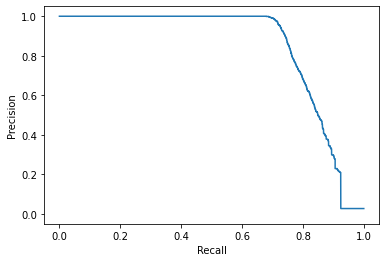

In [ ]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
precision, recall, _ = precision_recall_curve(pd.concat([fold['label'] for fold in folds]), y_prob)
plt.step(recall, precision, where='post')